In [ ]:
import xtrack as xt
import xobjects as xo
import xpart as xp

import ducktrack as dtk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from tqdm import tqdm

#### PLOT THE DATA #######
textwidth_cm = 16.50764  # Text width in cm
aspect_ratio = 0.618     # Aspect ratio (height/width) using the golden ratio

# Font sizes
label_fontsize = 10
legend_fontsize = 10
tick_fontsize = 8
colorbar_label_fontsize = 10
colorbar_tick_fontsize = 8
offset_text_fontsize = 8

# Convert text width from cm to inches
textwidth_in = textwidth_cm / 2.54

# Calculate figure size based on text width and aspect ratio
fig_width = textwidth_in
fig_height = textwidth_in * aspect_ratio

In [ ]:
# copyright ############################### #
# This file is part of the Xtrack Package.  #
# Copyright (c) CERN, 2021.                 #
# ######################################### #


# beta_rel = 0.305
beta_rel = 0.106
# gamma = 1.050
gamma = 1.006


current=0.4
cooler_length = 1.5 # m cooler length
radius_e_beam=25*1e-3

mass0=938.27208816*1e6 #ev/c^2

temp_perp = 100*1e-3 # <E> [eV] = kb*T
temp_long =  1*1e-3 # <E> [eV]
magnetic_field = 0.060 # T for LEIR
Z=1


c=299792458.0

p0c = mass0*beta_rel*gamma #eV/c


circumference = 182.43280000000 #m
T_per_turn = circumference/(c*beta_rel)
ms_per_turn = 1000*T_per_turn


beta_x=10 
beta_y=4
emittance=10*1e-6

arc=dtk.LinearTransferMatrix(Q_x=5.38518956965, Q_y=5.36921653748,
                            beta_x_0=beta_x, beta_x_1=beta_x,
                            beta_y_0=beta_y,  beta_y_1=beta_y,
                            alpha_x_0=0,   alpha_x_1=0,
                            alpha_y_0=0,   alpha_y_1=0,
                            disp_x_0=0,disp_x_1=0,
                            disp_y_0=0,    disp_y_1=0,
                            beta_s=1*1e40,
                            Q_s=0,
                            chroma_x=0.0, chroma_y=0
                                           
                 )


num_particles=int(1e4)

#x=np.random.normal(0,np.sqrt(5*emittance) ,num_particles),
#px=np.random.normal(0, np.sqrt(emittance/5), num_particles),
#x=np.linspace(1*1e-3, 20*1e-3, num_particles),
#px=np.random.uniform(0, 0, num_particles),

dtk_particle = dtk.TestParticles(
        
        mass0=mass0,
        p0c=p0c,
        x=np.random.normal(0,1e-40 ,num_particles),
        px=np.random.normal(0, np.sqrt(emittance/beta_x), num_particles),
        y=np.random.normal(0, 1e-40, num_particles),
        py=np.random.normal(0, 1e-40, num_particles),
        delta=np.random.normal(0, 1e-40, num_particles),
        zeta=np.random.normal(0, 1e-40, num_particles))

dtk_particle_copy_old=dtk_particle.copy()



In [38]:
0.01*1e3

10.0

In [30]:
#xp_cooler=1e-3

magnetic_field_ratio=1e-3

dtk_cooler = dtk.elements.ElectronCooler(current=current,
                    length=cooler_length,
                    radius_e_beam=radius_e_beam,
                    temp_perp=temp_perp, temp_long=temp_long,
                    magnetic_field=magnetic_field, magnetic_field_ratio=magnetic_field_ratio,
                    space_charge=0)


cooler = dtk.elements.ElectronCooler(current=current, length=cooler_length, radius_e_beam=radius_e_beam,
                                        temp_perp=temp_perp, temp_long=temp_long,
                                        magnetic_field=magnetic_field,magnetic_field_ratio=magnetic_field_ratio,
                                        space_charge=0,
                                        offset_px=0)

cooler_0 = dtk.elements.ElectronCooler(current=current, length=cooler_length, radius_e_beam=radius_e_beam,
                                        temp_perp=temp_perp, temp_long=temp_long,
                                        magnetic_field=magnetic_field,magnetic_field_ratio=0,
                                        space_charge=0,
                                        offset_px=0)


coolers = []
num_coolers=int(1e4)


for i in range(num_coolers):
    angle=np.random.normal(0,magnetic_field_ratio,1)
    #angle=np.random.uniform(-B_ratio,B_ratio,1)
    #print('angle:',angle)
    cooler_tiny = dtk.elements.ElectronCooler(current=current, length=cooler_length, radius_e_beam=radius_e_beam,
                                         temp_perp=temp_perp, temp_long=temp_long,
                                         magnetic_field=magnetic_field,magnetic_field_ratio=0,
                                         space_charge=0,
                                         offset_px=angle)
    coolers.append(cooler_tiny)



In [31]:
num_turns=int(1)



x=[]
px=[]
action = []
force = []
force_old = []
force_0 = []


for i in tqdm(range(num_turns)):
    x.append(dtk_particle.x)
    px.append(dtk_particle.px)
    
    action_temp = (dtk_particle.x**2/beta_x + beta_x*dtk_particle.px**2) #Joule sec
    action.append(action_temp)
    
   
    force_temp=[]        
    Fx,Fy,Fl=cooler.force(dtk_particle)
    force_old.append(Fx)

    force_x0,force_y0,force_l0=cooler_0.force(dtk_particle_copy_old)
    force_0.append(force_x0)

    for cooler_small in coolers:
        f1,f2,f3=cooler_small.force(dtk_particle)
        force_temp.append(f1)
        
        
    force_temp=np.array(force_temp)
    force=force_temp.mean(axis=0)  
    #force=np.squeeze(force)


x = np.array(x)
px = np.array(px)
action = np.array(action)
force = np.array(force).flatten().flatten()
force_old = np.array(force_old).flatten().flatten()
force_0 = np.array(force_0).flatten().flatten()


px_tot = p0c * px
beta_diff = px_tot / (mass0 * gamma)
v_diff = beta_diff * c

v_diff=v_diff.flatten().flatten()

sorted_indices = np.argsort(v_diff)
v_diff_sorted = v_diff[sorted_indices]
force_0_sorted = force_0[sorted_indices]
force_sorted = force[sorted_indices]
force_old_sorted = force_old[sorted_indices]

100%|██████████| 1/1 [00:13<00:00, 13.35s/it]


In [32]:
force_0.shape

(10000,)

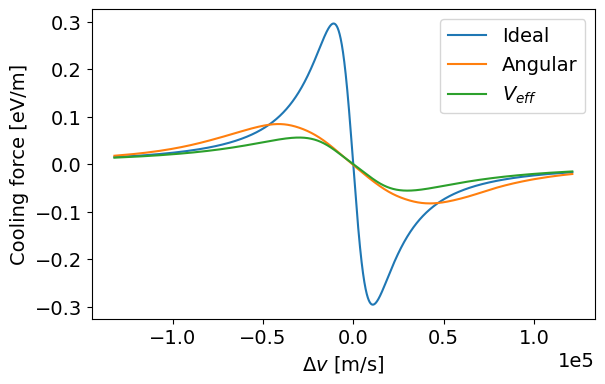

In [36]:
# Create the figure with the calculated dimensions
plt.figure(figsize=(fig_width, fig_height))

# Plot the data
plt.plot(v_diff_sorted, force_0_sorted, label='Ideal')
plt.plot(v_diff_sorted, force_sorted, label='Angular')
plt.plot(v_diff_sorted, force_old_sorted, label='$V_{eff}$')

# Set labels with appropriate font size
plt.xlabel('$\\Delta v$ [m/s]')
plt.ylabel('Cooling force [eV/m]')

# Add legend
plt.legend()
plt.ticklabel_format(axis='x', style='sci', scilimits=(-2, 2))
# Save the figure with high DPI
plt.savefig('angle_imperfection_force.png', dpi=300)

# Show the plot
plt.show()

In [34]:
# plt.scatter(px,force_0)